# FINAL

In [1]:
## Importing dependencies
import pandas as pd
import numpy as np

# to avoid GPU logs
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.utils import resample

In [2]:
# Loading dataset
data = pd.read_csv("DR_dataset_archive 3/trainLabels_cropped.csv")
data.drop(columns=['Unnamed: 0.1','Unnamed: 0'], inplace=True)

In [3]:
# Resampling and balancing dataset (using your code logic)
from imblearn.under_sampling import RandomUnderSampler
X = data['image']  
y = data['level']  
X_array = X.values.reshape(-1,1)
y_array = y.values.reshape(-1,1)

class_counts = {0: 25802, 1: 5288, 2: 2438, 3: 872, 4: 708}
target_count = class_counts[4]
undersampler = RandomUnderSampler(sampling_strategy={label: target_count for label in class_counts.keys() if label != 3})
X_resampled, y_resampled = undersampler.fit_resample(X_array, y_array)

In [4]:
# Create new dataframe with resampled data
new_X = [i[0] for i in X_resampled]
resampled_data = {'image': new_X, 'level': y_resampled}
balanced_data = pd.DataFrame(resampled_data)
balanced_data['image'] = balanced_data['image'] + '.jpeg'

In [5]:
# Splitting the data
train, val = train_test_split(balanced_data, test_size=0.2, random_state=42)
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 5

In [6]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory='DR_dataset_archive 3/resized_train_cropped/resized_train_cropped',
    x_col='image',
    y_col='level',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw')

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val,
    directory='DR_dataset_archive 3/resized_train_cropped/resized_train_cropped',
    x_col='image',
    y_col='level',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw')

Found 2963 validated image filenames.
Found 741 validated image filenames.


In [7]:
# Loading Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [8]:
# Adding custom CNN layers after Xception
x = base_model.output
x = Conv2D(64, kernel_size=(3,3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2))(x)
x = GlobalAveragePooling2D()(x)  # Global average pooling to reduce dimensions
x = Dense(1024, activation='relu')(x)  # Fully connected layer
x = Dropout(0.2)(x)  # Dropout for regularization
predictions = Dense(NUM_CLASSES, activation='softmax')(x)  # Final output layer

In [9]:
# Defining the model
model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
# Freezing the layers of Xception
for layer in base_model.layers:
    layer.trainable = False

In [11]:
# Compiling the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Training the model
history = model.fit(train_generator, validation_data=val_generator, epochs=40)

Epoch 1/40
93/93 [==============================] - 114s 1s/step - loss: 1.5111 - accuracy: 0.3125 - val_loss: 1.4680 - val_accuracy: 0.3509
Epoch 2/40
93/93 [==============================] - 131s 1s/step - loss: 1.3810 - accuracy: 0.3898 - val_loss: 1.4180 - val_accuracy: 0.3495
Epoch 3/40
93/93 [==============================] - 1493s 16s/step - loss: 1.3207 - accuracy: 0.4074 - val_loss: 1.3669 - val_accuracy: 0.3792
Epoch 4/40
93/93 [==============================] - 202s 2s/step - loss: 1.2841 - accuracy: 0.4232 - val_loss: 1.3544 - val_accuracy: 0.4022
Epoch 5/40
93/93 [==============================] - 122s 1s/step - loss: 1.2383 - accuracy: 0.4377 - val_loss: 1.4432 - val_accuracy: 0.3657
Epoch 6/40
93/93 [==============================] - 126s 1s/step - loss: 1.1956 - accuracy: 0.4637 - val_loss: 1.3438 - val_accuracy: 0.4035
Epoch 7/40
93/93 [==============================] - 146s 2s/step - loss: 1.1761 - accuracy: 0.4600 - val_loss: 1.3930 - val_accuracy: 0.4035
Epoch 8/40


In [13]:
# Continue training for an additional 10 epochs
history_additional = model.fit(train_generator, validation_data=val_generator, epochs=10)

Epoch 1/10
93/93 [==============================] - 291s 3s/step - loss: 0.4324 - accuracy: 0.8140 - val_loss: 3.8569 - val_accuracy: 0.3819
Epoch 2/10
93/93 [==============================] - 297s 3s/step - loss: 0.4317 - accuracy: 0.8188 - val_loss: 3.8189 - val_accuracy: 0.3887
Epoch 3/10
93/93 [==============================] - 287s 3s/step - loss: 0.5278 - accuracy: 0.7779 - val_loss: 3.1588 - val_accuracy: 0.3779
Epoch 4/10
93/93 [==============================] - 297s 3s/step - loss: 0.3725 - accuracy: 0.8414 - val_loss: 3.7763 - val_accuracy: 0.3725
Epoch 5/10
93/93 [==============================] - 329s 4s/step - loss: 0.3076 - accuracy: 0.8640 - val_loss: 4.0137 - val_accuracy: 0.3738
Epoch 6/10
93/93 [==============================] - 351s 4s/step - loss: 0.3942 - accuracy: 0.8292 - val_loss: 3.8314 - val_accuracy: 0.3455
Epoch 7/10
93/93 [==============================] - 325s 4s/step - loss: 0.4861 - accuracy: 0.7948 - val_loss: 3.5229 - val_accuracy: 0.3725
Epoch 8/10
93

In [14]:
# Saving the model

model.save('drdCustomCNN_Xception_50epochs_NOUNDERSAMPLE.keras')

/opt/anaconda3/envs/PRS3/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [16]:
model.save('drdCustomCNN_Xception_50epochs_NOUNDERSAMPLE.h5')

In [15]:
model.save('drdCustomCNN_Xception_50epochs_NOUNDERSAMPLE.weights.h5')

/opt/anaconda3/envs/PRS3/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


#### Testing

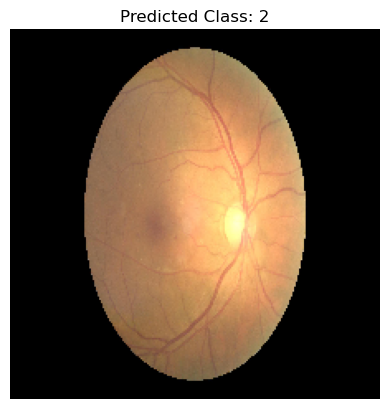

In [18]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the image
img_path = 'combine_dataset/classifier_one_data/ODIR-5K/ODIR-5K/Training Images/6_right.jpg'  # Replace with your image path
# img_path = 'DR_dataset_archive 3/resized_train_cropped/resized_train_cropped_1024/16_right.jpeg'  # Replace with your image path
target_size = (224, 224)  # Model's expected input size
img = image.load_img(img_path, target_size=target_size)  # Resize image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize if needed

# Make predictions
prediction = model.predict(img_array)

# Interpret predictions
predicted_class = np.argmax(prediction)  # For multi-class
# For binary classification, use:
# predicted_class = (prediction > 0.5).astype(int)

# Display the result
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()


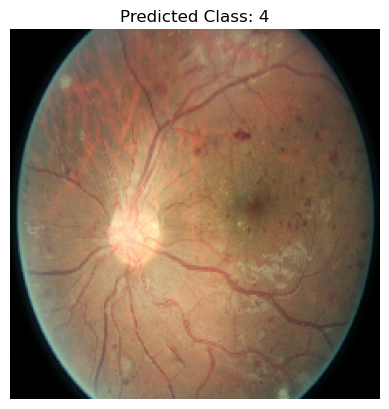

In [19]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the image
# img_path = 'combine_dataset/classifier_one_data/ODIR-5K/ODIR-5K/Training Images/6_right.jpg'  # Replace with your image path
img_path = 'DR_dataset_archive 3/resized_train_cropped/resized_train_cropped_1024/16_right.jpeg'  # Replace with your image path
target_size = (224, 224)  # Model's expected input size
img = image.load_img(img_path, target_size=target_size)  # Resize image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize if needed

# Make predictions
prediction = model.predict(img_array)

# Interpret predictions
predicted_class = np.argmax(prediction)  # For multi-class
# For binary classification, use:
# predicted_class = (prediction > 0.5).astype(int)

# Display the result
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()


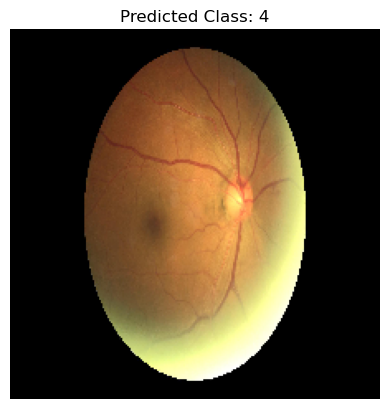

In [21]:
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load and preprocess the image
img_path = 'combine_dataset/classifier_one_data/ODIR-5K/ODIR-5K/Training Images/11_right.jpg'  # Replace with your image path
# img_path = 'DR_dataset_archive 3/resized_train_cropped/resized_train_cropped_1024/16_right.jpeg'  # Replace with your image path
target_size = (224, 224)  # Model's expected input size
img = image.load_img(img_path, target_size=target_size)  # Resize image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize if needed

# Make predictions
prediction = model.predict(img_array)

# Interpret predictions
predicted_class = np.argmax(prediction)  # For multi-class
# For binary classification, use:
# predicted_class = (prediction > 0.5).astype(int)

# Display the result
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class}')
plt.axis('off')
plt.show()


Inference
- Xception approach predicts correctly